# Understat Series : Probabilities and Random



**By Jose Gonzalez**

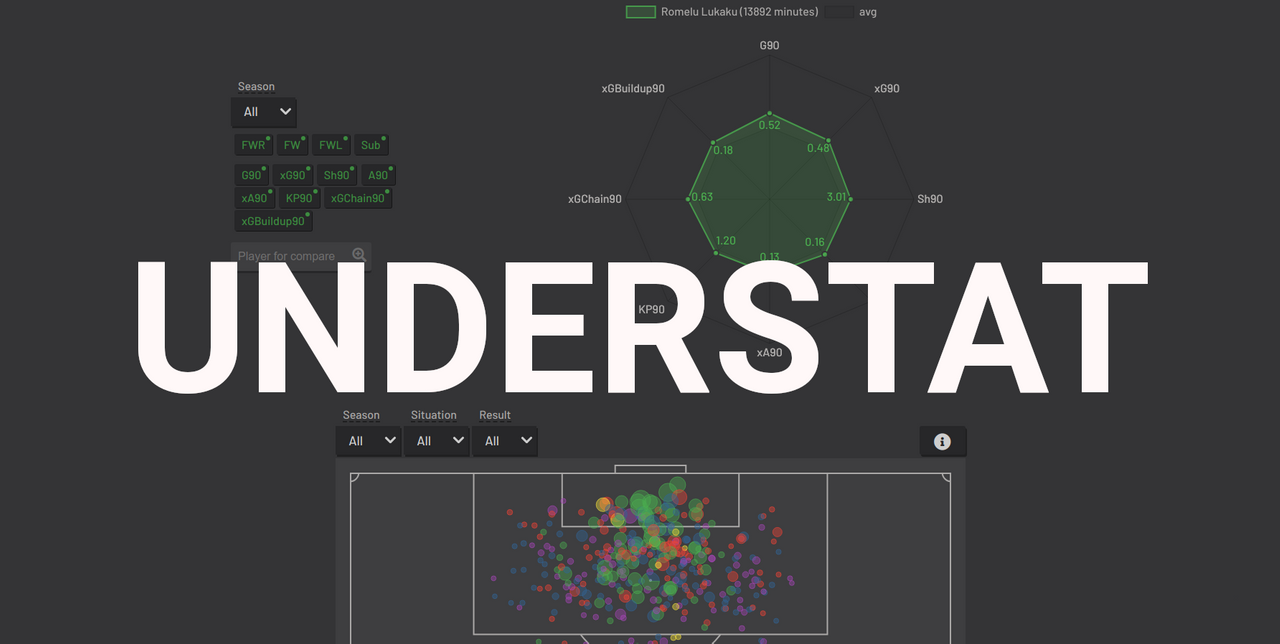

<a id="1."></a>
# Introduction

<a id="1.1"></a>
# Notebook content

* [1. Introduction](#1.)
    - [1.1. Notebook Content.](#1.1)
* [2. Importing libraries.](#2.)
* [3. Extracting the data.](#3.)
    - [3.1. xG Data.](#3.1)
    - [3.2. Stats data.](#3.2)
* [4. Expected Points](#4.)
* [5. Team xG Distribution](#5.)
* [6. Goals Probability](#6.)
* [7. Random probabilities FC Python.](#7.)
* [8. Most likely outcome](#8.)
* [9. References](#9.)
* [10. Other notebooks](#10.)

<a id="2."></a>
# Importing Libraries

In [18]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.patheffects as path_effects
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib.patches import Arc
import numpy as np
from highlight_text import fig_text
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from scipy.stats import poisson
import random 
import requests
import json
import re
from pandas.io.json import json_normalize
import pandas as pd

<a id="3."></a>
# Extracting the data
Let's now scrape the data the xG data for the match Real Sociedad 1 vs FC Barcelona 6 

<a id="3.1"></a>
## xG Data

In [34]:
# Entering Real Sociedad vs Barcelona match link
link = "https://understat.com/match/15054"
res = requests.get(link)
soup = BeautifulSoup(res.content,'lxml')
scripts = soup.find_all('script')

# Get the shotsData, it's the second script executed in order
strings = scripts[1].string 

# Getting rid of unnecessary characters from json data
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)

df_h = pd.DataFrame(data['h'])
df_a = pd.DataFrame(data['a'])
df = df_h.append(df_a)

# Changing the data types 
df['xG'] = df['xG'].astype('float')
df['X'] = df['X'].astype('float')
df['Y'] = df['Y'].astype('float')

# Dividing the df between away and home again
df_h = pd.DataFrame(df[df['h_a']=='h'])
df_a = pd.DataFrame(df[df['h_a']=='a'])

# List for xG 
h_xG = df_h['xG'].tolist()
a_xG = df_a['xG'].tolist()

<a id="3.2"></a>
## Stats Data
Apart from the xG shots data needed we are also scraping the stats data from the match : 
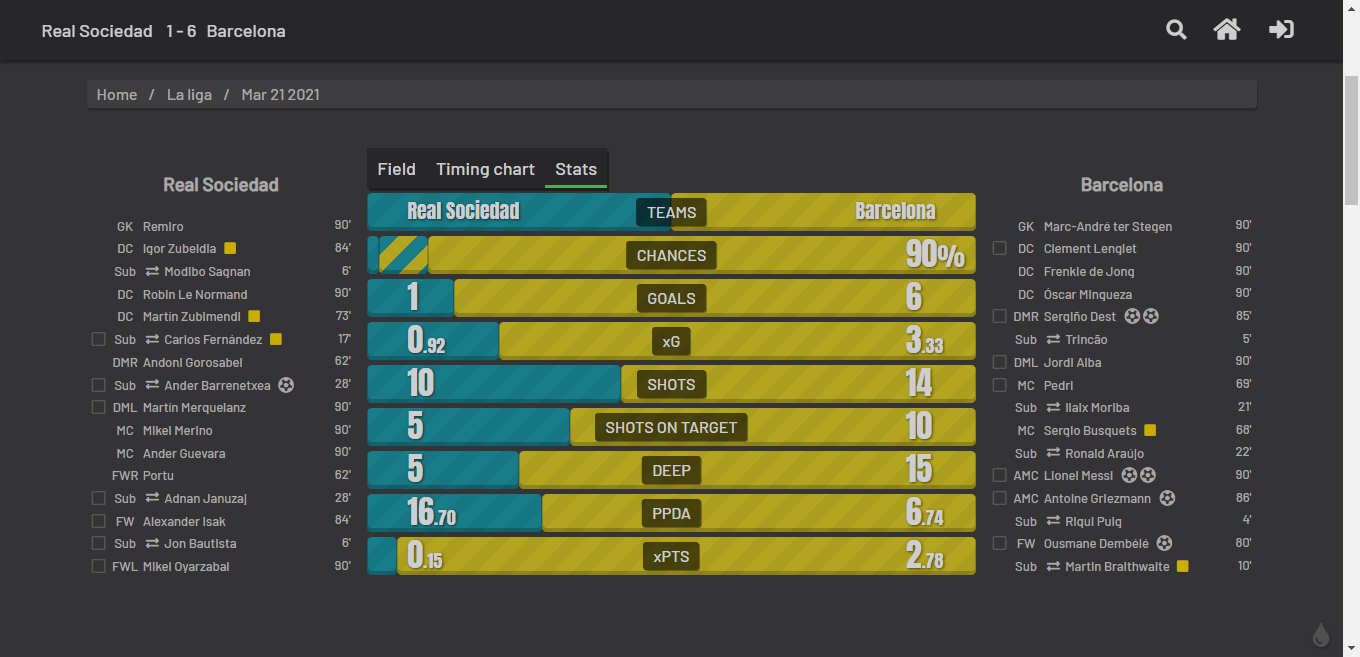

In [35]:
response = requests.get('https://understat.com/match/15054')

match_info = re.search("match_info\s+=\s+JSON.parse\('([^']+)", response.text)
decoded_string = bytes(match_info.groups()[0], 'utf-8').decode('unicode_escape')
matchObj = json.loads(decoded_string)

stats = pd.Series(matchObj)
stats =  pd.DataFrame(stats).T

In [60]:
# Changing data types
stats = stats.astype({"h_w": float, "h_l": float, "h_d" : float, "a_xg" : int , "h_xg" : int})

# Away stats 
a_goals = stats.a_goals[0]
a_xg = stats.a_xg[0]
a_shot = stats.a_shot[0]
a_shotOnTarget = stats.a_shotOnTarget[0]
a_ppda = stats.a_ppda[0]
a_deep = stats.a_deep[0]
date = stats.date[0]

# Home stats
h_goals = stats.h_goals[0]
h_xg = stats.h_xg[0]
h_shot = stats.h_shot[0]
h_shotOnTarget = stats.a_shotOnTarget[0]
h_ppda = stats.h_ppda[0]
h_deep = stats.h_deep[0]
h_w = stats.h_w[0]*100
h_l = stats.h_l[0]*100
h_d = stats.h_d[0]*100

In [21]:
stats

,id,fid,h,a,date,league_id,season,h_goals,a_goals,team_h,...,h_l,league,h_shot,a_shot,h_shotOnTarget,a_shotOnTarget,h_deep,a_deep,a_ppda,h_ppda
0,15054,1492274,140,148,2021-03-21 20:00:00,4,2020,1,6,Real Sociedad,...,0.9008,La liga,10,14,5,10,5,15,6.7419,16.7037


<a id="4."></a>
# Expected points

Let's now calculate Expected points,xpts, the way to calculate is multiplying the win probability for 3 and the draw probability for 1 and then the expected points are obtained: 

In [22]:
away_xpoints = np.round(3*(h_l/100) + 1*(h_d/100),2)
home_xpoints = np.round(3*(h_w/100) + 1*(h_d/100),2)
print("Home expected points : {}\nAway expected points : {}".format(home_xpoints,away_xpoints))

Home expected points : 0.15
Away expected points : 2.78


<a id="5."></a>
# Teams xG Distribution
Now let's take a look at how the xG was distributed for the 2 tema

In [10]:
# Total xG per player
homexg = df_h.groupby("player")["xG"].sum().reset_index()
awayxg = df_a.groupby("player")["xG"].sum().reset_index()

In [11]:
# Creating lists for the xG
texty = homexg['xG'].tolist()
namesh = homexg['player'].tolist()
namesa = awayxg['player'].tolist()
# Rounding the numebers
pppp = np.round(pd.Series(awayxg.xG),3)
nnnn = np.round(pd.Series(homexg.xG),3)

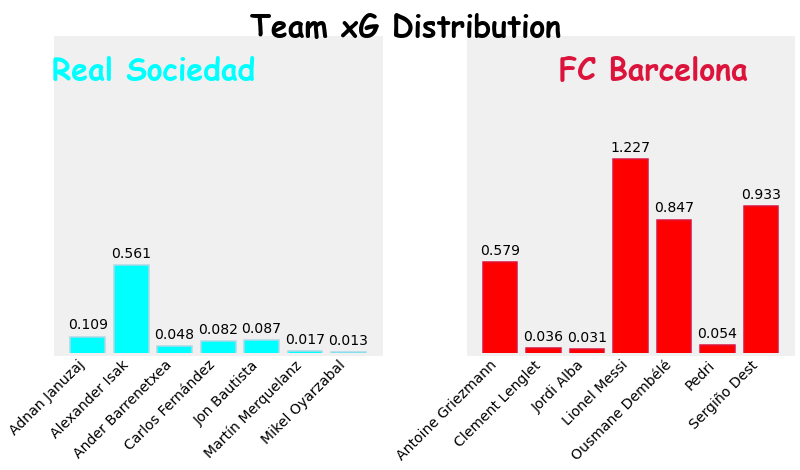

In [12]:
fig = plt.figure(figsize=(11,6),constrained_layout=True)
plt.style.use('fivethirtyeight')
gs = fig.add_gridspec(nrows=1,ncols=2)

# First plot
ax1 = fig.add_subplot(gs[0,0])
ax1.bar(homexg['player'] ,homexg['xG'],color='cyan',edgecolor='lightblue', lw=1.5)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
for i in range(nnnn.shape[0]):
    ax1.text(i, nnnn.values[i]+0.05, nnnn.values[i], horizontalalignment='center')
plt.yticks(np.linspace(0,2,5))
plt.yticks([])
plt.grid(False)

# Second plot
ax2 = fig.add_subplot(gs[0,1])
ax2.bar(awayxg['player'] ,awayxg['xG'],color='red',edgecolor='crimson', lw=1.5)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
for i in range(pppp.shape[0]):
    ax2.text(i, pppp.values[i]+0.05, pppp.values[i], horizontalalignment='center')
plt.yticks(np.linspace(0,2,5))
plt.yticks([])
plt.grid(False)

fig_text(0.31,1.05 ,s="Team xG Distribution",font='Comic Sans MS',fontsize=30,fontweight="bold")
fig_text(0.06,0.95, s="Real Sociedad",font='Comic Sans MS',fontsize=30,fontweight="bold",color='cyan')
fig_text(0.7,0.95, s="FC Barcelona",font='Comic Sans MS',fontsize=30,fontweight="bold",color='crimson')

----

<a id="6."></a>
# Goal probability
Now let's dive a bit into the probabilities of each team scoring x number of goals, with the max being 5 or higher, 5+.

In [13]:
# Probabilities 
max_goals =6 

xgbarca = np.cumsum(a_xG)[-1]
xgreal = np.cumsum(h_xG)[-1]

gProbsBarcelona = [poisson.pmf(i,xgbarca) for i in range(max_goals)]
gProbsSociedad = [poisson.pmf(i,xgreal) for i in range(max_goals)]

barca = np.round((np.array(gProbsBarcelona) * 100),2)
sociedad = np.round((np.array(gProbsSociedad) * 100),2)

findfont: Font family ["'Comic Sans MS"] not found. Falling back to DejaVu Sans.


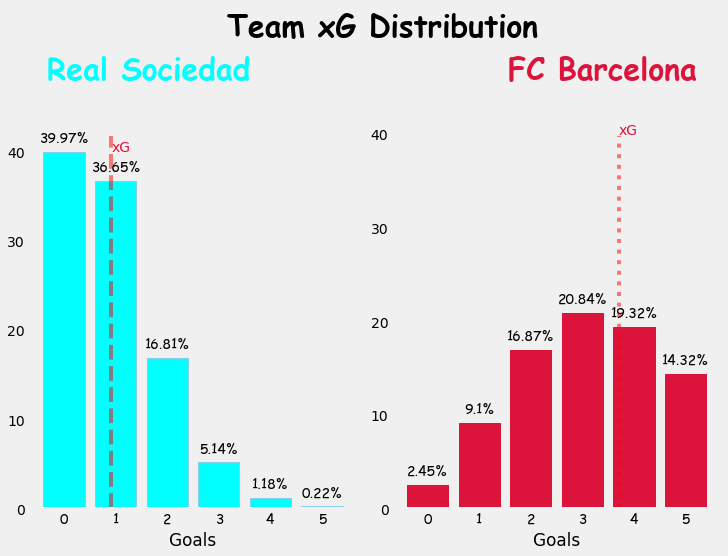

In [14]:
fig = plt.figure(figsize=(10,6),constrained_layout=True)
plt.style.use('fivethirtyeight')
gs = fig.add_gridspec(nrows=1,ncols=2)

# First plot
ax1 = fig.add_subplot(gs[0,0])
plt.bar(range(len(sociedad)),sociedad,color='cyan',edgecolor='skyblue', lw=1., zorder = 0)
plt.xticks(range(len(sociedad)))
plt.axvline(xgreal,linestyle='--',color='red',alpha=0.5)
plt.text(xgreal,40,'xG',color='crimson',font="'Comic Sans MS")
plt.xlabel('Goals')
plt.yticks([])
plt.grid(False)
for i in range(len(sociedad)):
    plt.annotate(str(sociedad[i])+"%", (range(len(sociedad))[i], sociedad[i]+1.5),c='black',size=8,ha='center',va='center',fontweight='bold',font='Comic Sans MS')
plt.xticks(font='Comic Sans MS')
plt.yticks(np.linspace(0,40,5))

# Second plot
ax2 = fig.add_subplot(gs[0,1])
plt.bar(range(len(barca)),barca,color='crimson',edgecolor='crimson', lw=1., zorder = 0)
plt.xticks(range(len(barca)))
plt.axvline(xgbarca,linestyle=':',color='red',alpha=0.5)
plt.text(xgbarca,40,'xG',color='crimson',font="'Comic Sans MS")
plt.xlabel('Goals')
plt.yticks([])
plt.grid(False)
for i in range(len(barca)):
    plt.annotate(str(barca[i])+"%", (range(len(barca))[i], barca[i]+1.5),c='black',size=8,ha='center',va='center',fontweight='bold',font='Comic Sans MS')
plt.xticks(font='Comic Sans MS')
plt.yticks(np.linspace(0,40,5))

fig_text(0.31,1.25 ,s="Team xG Distribution",font='Comic Sans MS',fontsize=30,fontweight="bold")
fig_text(0.06,1.15, s="Real Sociedad",font='Comic Sans MS',fontsize=30,fontweight="bold",color='cyan')
fig_text(0.7,1.15, s="FC Barcelona",font='Comic Sans MS',fontsize=30,fontweight="bold",color='crimson')

----

<a id="7."></a>
# Random probabilities FC Python
Now instead of using the probabilities scraped by Understat, let's calculate it ourselves and here all the credit goes to FC Python for his unbelievable [tutorial](http://fcpython.com/python-basics/random-with-xg) on it :  

In [40]:
def calculateWinner(home, away):
    HomeGoals = 0
    AwayGoals = 0
    
    def testShots(shots):
        Goals = 0
        
        for shot in shots:
            if random.random() <= shot:
                Goals += 1
        return Goals
    
    HomeGoals = testShots(home)
    AwayGoals = testShots(away)
    
    #This is all that changes from above
    #We now pass a simple string, rather than ask for a print out.
    if HomeGoals > AwayGoals:
        return("home")
    elif AwayGoals > HomeGoals:
        return("away")
    else:
        return("draw")
    

In [51]:
def calculateChance(team1, team2):
    home = 0;
    away = 0;
    draw = 0;
    
    for i in range(0,10000):
        matchWinner = calculateWinner(team1,team2)
        if matchWinner == "home":
            home +=1
        elif matchWinner == "away":
            away +=1
        else:
            draw +=1
    
    home = home/100
    away = away/100
    draw = draw/100
    
    win_prob = [home,away,draw]
    return win_prob

In [52]:
calculateWinner(h_xG, a_xG)
prob_list = calculateChance(h_xG,a_xG)

In [54]:
prob_list

[1.8, 92.73, 5.47]

Now let's compare the 2 ways of obtaining the win probability, first one is scraping it from Understat as seen before and the second one is using the function written by FC Python : 

In [58]:
# Prob list obtained by Understat
display(prob_list)
# Probabilities obtained by FC Python function
display(h_d,h_l,h_w)

[1.8, 92.73, 5.47]

7.630000000000001

90.08

2.29

As we can see it's only minor differences such as instead of 92% it's now 90$ and so on

<a id="8."></a>
# Most likely outcome

Check this great notebook out to find out more about most likely outcome and other stuff such as obtaining probabilities through grids and other stuff.

https://github.com/bfrentz/postmatch/blob/master/postmatch_analyzer.ipynb



<a id="9."></a>
# References

These were the main references for this notebook: 

   1. https://github.com/bfrentz/postmatch/blob/master/postmatch_analyzer.ipynb 
   
   
   2. https://github.com/parth1902/Understat-Data-Simulator 
   
   
   3. [FC Python Webpage](http://fcpython.com/python-basics/random-with-xg)
   
   

<a id="10."></a>
# Other notebooks 

Here are some other notebooks on the subject : 

   1. https://github.com/Param9498/SoccerBetting
    
    
   2. https://github.com/aritrartira/xG-Outcome-Predcitor
    
    
   3. https://github.com/aritrartira/Football-Statistics-Visualisations 
   
   
   4. https://wiscostret.wordpress.com/2019/04/20/win-probability-expected-points-and-epa-player-value-in-football/
    